# Logistic Regression

Today we are going to learn about Logistic Regression as our first example of Classification. Recall Classification is the branch of ML where we try to predict a **category** for a given input, instead of a real value. Let's get to an example!

In [1]:
# Normal setup and import cells with unimportant parts

import numpy as np 
from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.special import expit
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import l1_min_c

font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
SPECIES_MAP = {'Setosa': 0, "Versicolour": 1, "Virginica": 2}

In [2]:
# Helper methods to create our plots. This part is a lot of boilerplate code o =n using matplotlib that is not core to the lesson in question.

def add_legend(color_map=SPECIES_MAP, cm=plt.cm.coolwarm, **kwargs):
    markers = [plt.Line2D([0,0],[0,0],color=cm(color*100), marker='o', linestyle='') for color in color_map.values()]
    plt.legend(markers, color_map.keys(), numpoints=1, **kwargs)

    
def plot_with_coloured_labels_2d(x_data, y_data):
    plt.figure(1, figsize=(20, 15))
    plt.scatter(x_data[:, 0], x_data[:, 1], c=plt.cm.coolwarm(y_data*100), s=300)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.title("Species in the Iris Dataset by sepal length and width")
    plt.plot([4.5], [3.0], marker='o', markersize=30, color="red")
    plt.text(4.6, 2.9, s="Which species do we assign?", fontdict={"size": 15, "color": "red"})
    add_legend()
    plt.show()

def plot_with_coloured_labels_1d(x_data, y_data, threshold=False, color_map=SPECIES_MAP):
    only_setosa = np.vectorize(lambda x: 0 if x == 0 else 1)(y_data)
    plt.figure(1, figsize=(10, 5))
    plt.scatter(x_data[:, 0], y=only_setosa, c=plt.cm.coolwarm(only_setosa*100), s=300)
    plt.xlabel('Sepal length')
    plt.title("Species in the Iris Dataset by sepal length")
    plt.yticks([0,1,2])
    markers = [plt.Line2D([0,0],[0,0],color=plt.cm.coolwarm(color*100), marker='o', linestyle='') for color in color_map.values() if color != 2]
    plt.legend(markers, ['Setosa', 'Not Setosa'], numpoints=1)
    plt.plot(4.5, 0, marker='o', markersize=30, color="red")
    if threshold:
        plt.plot([threshold_linear_reg, threshold_linear_reg], [0,2], color="violet")
    plt.show()

def plot_with_coloured_labels_1d_and_reg(x_data, y_data, reg, threshold=False, color_map=SPECIES_MAP):
    only_setosa = np.vectorize(lambda x: 0 if x == 0 else 1)(y_data)
    plt.figure(1, figsize=(10, 10))
    plt.scatter(x_data[:, 0], y=only_setosa, c=plt.cm.coolwarm(only_setosa*100), s=300)
    plt.xlabel('Sepal length')
    plt.title("Species in the Iris Dataset by sepal length")
    markers = [plt.Line2D([0,0],[0,0],color=plt.cm.coolwarm(color*100), marker='o', linestyle='') for color in color_map.values() if color != 2]
    plt.legend(markers, ['Setosa', 'Not Setosa'], numpoints=1)
    plt.plot(4.5, 0, marker='o', markersize=30, color="red")
    y_reg_pred = reg.predict(x_data[:, 0].reshape(-1, 1))
    data = np.column_stack([x_data[:, 0], y_reg_pred])
    plt.plot(data[:, 0], data[:, 1], color="yellow", label="Regression Line")
    if threshold:
        plt.plot([threshold_linear_reg, threshold_linear_reg], [0,2], color="violet")
    plt.show()

def plot_cost_function_deduction(x_data, y_data, color_map=SPECIES_MAP):
    only_setosa = np.vectorize(lambda x: 0 if x == 0 else 1)(y_data)
    plt.figure(1, figsize=(20, 10))
    plt.scatter(x_data[:, 0], y=only_setosa, c=plt.cm.coolwarm(only_setosa*100), s=300)
    plt.xlabel('Sepal length')
    plt.title("Species in the Iris Dataset by sepal length")
    plt.yticks([0,1,2])
    markers = [plt.Line2D([0,0],[0,0],color=plt.cm.coolwarm(color*100), marker='o', linestyle='') for color in color_map.values() if color != 2]
    plt.legend(markers, ['Setosa', 'Not Setosa'], numpoints=1, loc=4)
    plt.arrow(x=7, y=1, dx=0, dy=-0.1, length_includes_head=True, head_width=0.05, head_length=0.03)
    plt.text(6, 0.82, s="This value should be penalized heavily\n if predicted Setosa (y=0)")
    plt.arrow(x=4.2, y=0, dx=0, dy=0.1, length_includes_head=True, head_width=0.05, head_length=0.03)
    plt.text(4.2, 0.11, s="This value should not be penalized\n if predicted  Setosa (y=0)")
    plt.show()

def plot_setosa_cost():
    x = np.linspace(4,7.99)
    y = -np.log((8-x)/4)
    plt.plot(x,y)
    plt.title("Cost function to predict Setosa correctly")
    plt.show()

def plot_not_setosa_cost():
    x = np.linspace(4.01,8)
    y = -np.log((x-4)/4)
    plt.plot(x,y)
    plt.title("Cost function to predict Not Setosa correctly")
    plt.show()

def plot_cost_function():
    x = np.linspace(4.01,7.99)
    y_0 = -np.log((8-x)/4)
    y_1 = -np.log((x-4)/4)
    plt.figure(1, figsize=(20, 10))
    plt.plot(x,y_0, label="Cost function if model predicts Setosa (y=0)")
    plt.plot(x, y_1, label="Cost function if model predicts Not Setosa (y=1)")
    plt.title("Cost function for classification")
    plt.legend(prop={'size': 14})
    plt.show()

def plot_logistic():
    x = np.linspace(-5, 5)
    y = expit(x)
    plt.plot(x, y)
    plt.plot([0, 0], [0,0.5], color="violet", linestyle='dashed')
    plt.plot([-5, 0], [0.5,0.5], color="violet", linestyle='dashed')
    plt.title("Logistic Function")
    plt.show()

def plot_model(x_data, logistic_reg_model):
    plt.figure(1, figsize=(20, 15))
    y_data = logistic_reg_model.predict(x_data)
    plt.scatter(x_data[:, 0], x_data[:, 1], c=plt.cm.coolwarm(y_data*100), s=300)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.title("Classification of Iris Dataset by sepal length and width")
    add_legend()
    plt.show()

def plot_accuracies(inverse_proportion_outliers, accuracies, regularized_accuracies):
    plt.figure(1, (10,10))
    plt.plot(100/inverse_proportion_outliers, accuracies, label="Non-regularized model", color="b")
    plt.plot(100/inverse_proportion_outliers, regularized_accuracies, label="Regularized model", color="r")
    plt.xlabel("Proportion of Outliers")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Evolution of accuracy with % of outliers")
    plt.show()

def plot_gridsearch_cv(param_grid, results, scoring, adjustable_param="C"):
    plt.figure(figsize=(20, 15))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)
    plt.xlabel(f"Inverse of regularization strength: {adjustable_param}")
    plt.ylabel("Score")
    plt.grid()
    ax = plt.axes()
    ax.set_xlim(0, param_grid[adjustable_param].max())
    ax.set_ylim(0.0, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results[f'param_{adjustable_param}'].data, dtype=float)

    for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid('off')
    plt.show()

def get_heatmap(matrix, labels):
    plt.figure(1, (10,10))
    sns.heatmap(matrix, annot=True, cmap="RdYlGn", xticklabels=labels, yticklabels=labels)
    plt.title("Normalized confusion matrix of each classes predictions", fontdict={"size":16})
    plt.show()

The problem becomes, given the following dataset of flowers (a famous dataset called *Iris* dataset), if we spot a new Iris flower in the red dot, which species should we assign? it would be clever to have a model that outputs Setosa, since that is the species of the sorrounding flowers.

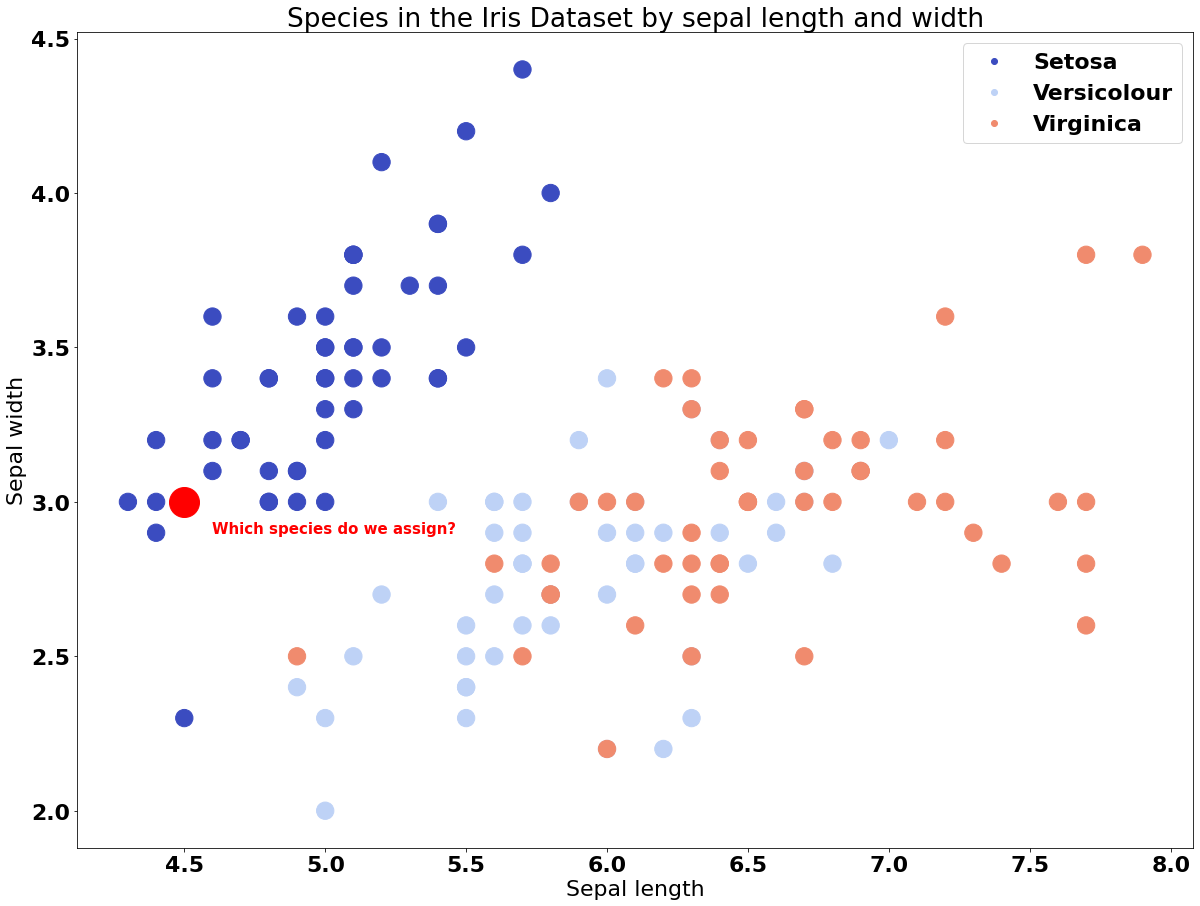

In [3]:
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features - sepal length and sepal width.
Y = iris.target
plot_with_coloured_labels_2d(X,Y)

#### How would **you** think of a solution to this problem?

## Simplify the problem

Now the problem is stated, let's think of a solution to a simplified problem. Let's only use the Sepal length for now and let's predict only one class [Setosa]!

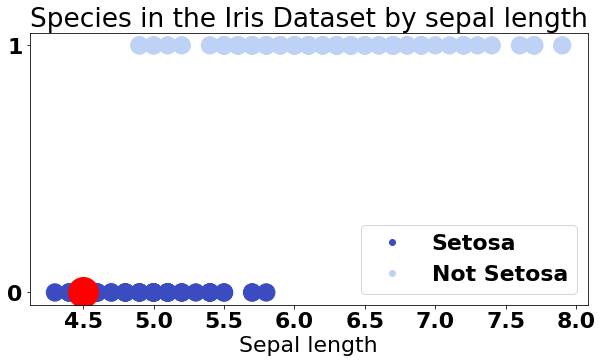

In [4]:
plot_with_coloured_labels_1d(X,Y)

We need some value of Sepal Length such that any value below it would be Setosa and it woudl be not if it's greater. One way to do it using what we know, is Linear Regression: If it returns a value greater than, say 0.5, then it is not Setosa, let's try it!

In [5]:
# Exercise 1: Build a Linear Regression model to fit the first feature of the dataset X (Sepal Length)

reg = None # Change None with fitted model (1/2 lines)

# Solution 1 : reg = LinearRegression().fit(X[:, 0].reshape(-1, 1), np.vectorize(lambda x: 0 if x == 0 else 1)(Y))
if reg is not None:
    plot_with_coloured_labels_1d_and_reg(X, Y, reg)


To find such threshold value, we only need to solve the equation:  \\begin{equation*} A*X + b = 0.5 \end{equation*}.

In [6]:
if reg is not None:
    # Get parameters of Model
    slope = reg.coef_
    intercept = reg.intercept_

    # Solve X such that AX + b = 0.5
    threshold_linear_reg = np.roots([slope, intercept - 0.5])[0]
    print(f"The threshold by linear regression would be {threshold_linear_reg}")
    plot_with_coloured_labels_1d_and_reg(X,Y, reg=reg, threshold=threshold_linear_reg)

It would look like this alternative has some sense into it, however, **what problems do you think we could have?**

## Another approach

One issue we have is , by how Linear Regression works, the model will try to reduce the distance between the two extreme points and the line. Therefore, we are not trying to make the maximum number of correct classifications within the training set! What if we try to maximize that measure instead? How would that cost function look like?

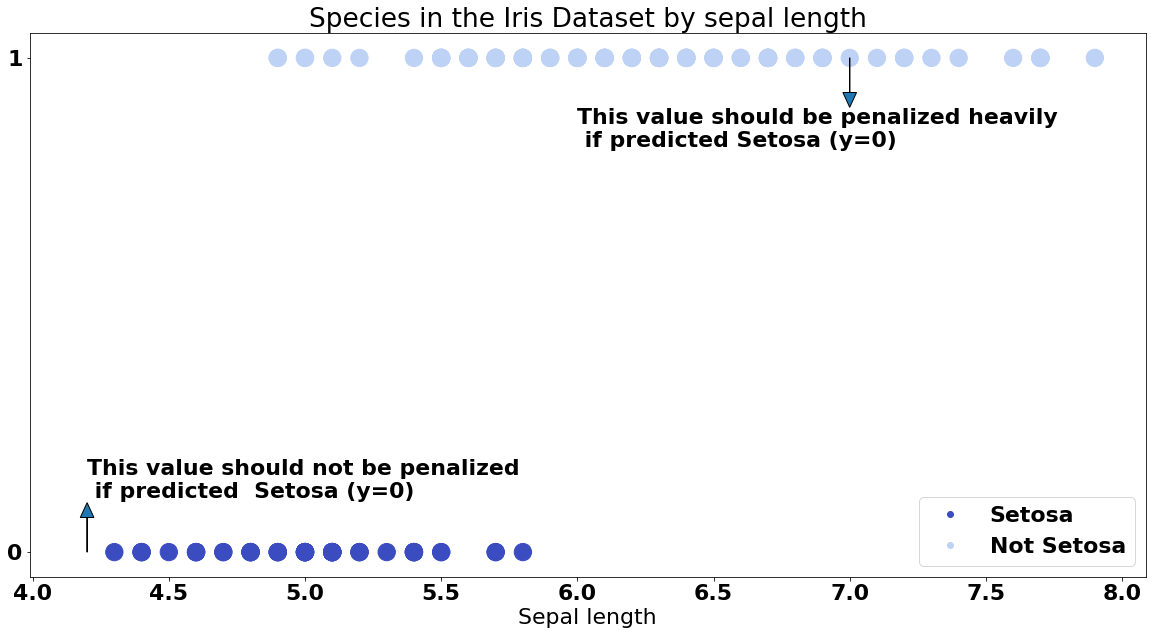

In [7]:
plot_cost_function_deduction(X,Y)

So, making a cost function that predicts Setosa correctly should be of the following form:

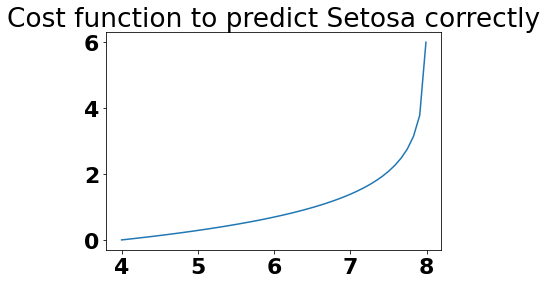

In [8]:
plot_setosa_cost()

This is because values with short sepal length would get small cost, while high sepal values would imply a high cost.

As we have seen previously from Linear Regression, this makes the optimizer choose a model that opts to assign high sepal length to other classes rather than *Setosa*. Now what we need is the other way around, to force a high value to avoid Setosa and be other one. It should have the following form:

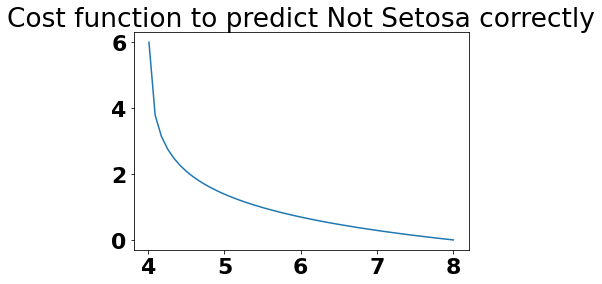

In [9]:
plot_not_setosa_cost()

This way, if we combine this two by adding them, we end up with a cost function that could optimise what we want!

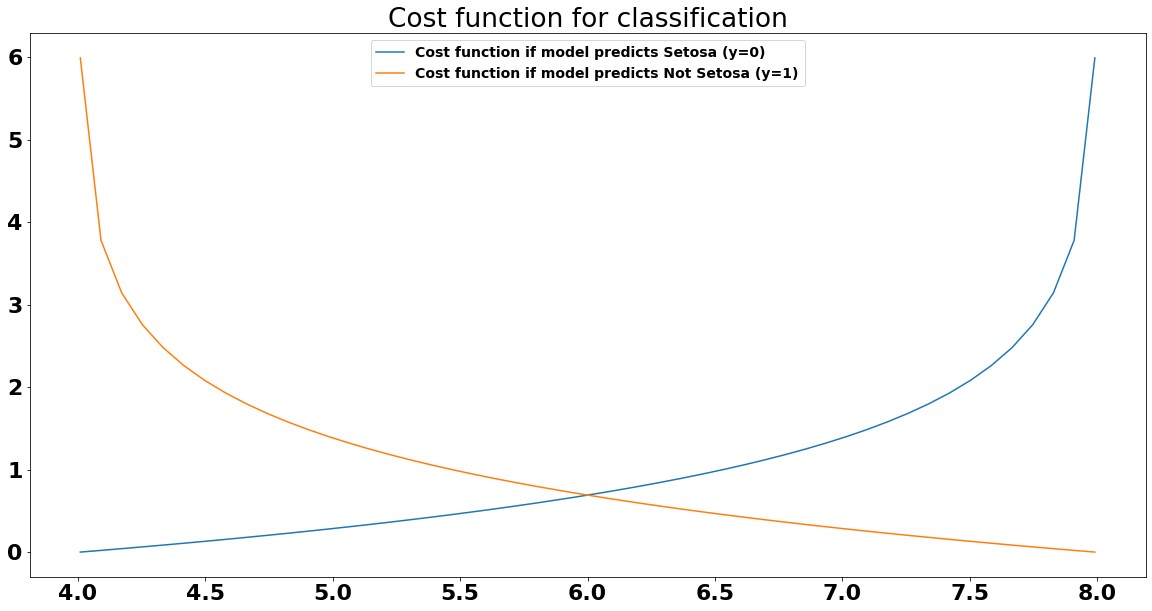

In [10]:
plot_cost_function()

 This cost function is called **Log Loss / Cross entropy / Log Likelihood** and will be the cost function of our new classification model.


Now we only need to think of the best model!

### Finding the Model

Another issue Linear Regression had, was that it doesn't "know" of these classes, it only tries to predict a value to be a function of the features! It would be great to have a way of using the classes information and then, from that, output a **probability** of getting a class! How do you think we can do that?

From math there is a great trick to do this using a function called the **logistic function** that outputs values between 0 and 1

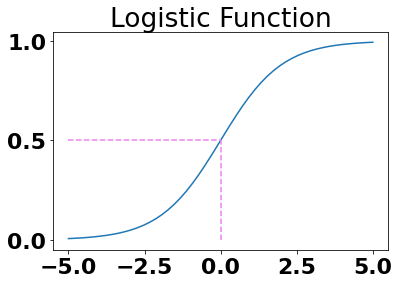

In [11]:
plot_logistic()

The logistic regression is a model that composes the logistic function with the linear regression to output a **probability** of be of class y=1 to a given input *x*: \\begin{equation*} y = logistic(A*x + b) \end{equation*}.

Let's fit a logistic regression model.

In [12]:
logreg = LogisticRegression()  # Just like Linear Regression, it is on the same linear_model package!
only_setosas = np.vectorize(lambda x: 0 if x == 0 else 1)(Y) # We collapse values of Y 1 and 2 to 1 so we predict only 1 class
logreg.fit(X[:,0].reshape(-1, 1), only_setosas)
X_test = np.array([5, 8])
y_pred = logreg.predict(X_test.reshape(-1, 1))
predictions = [{0: "Setosa", 1: "Not Setosa"}.get(value) for value in y_pred]
print(f"The class predicted for Sepal length {X_test} cm is {predictions}")

The class predicted for Sepal length [5 8] cm is ['Setosa', 'Not Setosa']


Excellent! Let's do a new exercise and create a Logistic Regression model to predict any of the three classes by Sepal length, let's then plot how the predictions work.

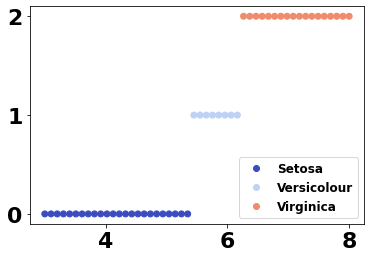

In [13]:
logistic_model = LogisticRegression()
logistic_model.fit(X[:, 0].reshape(-1,1), Y)

test_sepal_length = np.linspace(3, 8)
predicted_classes = logistic_model.predict(test_sepal_length.reshape(-1, 1)) 
plt.scatter(test_sepal_length, predicted_classes, c=plt.cm.coolwarm(predicted_classes*100))
add_legend(loc=4, prop={"size": 12})
plt.show()

#### Optional Exercise:

Can you find the (approximate, not exact) values of Sepal length such that the model changes from classifying *Setosa* to *Versicolour*, as well as the (approximate) value that it changes from *Versicolour* to *Virginica*? Plot the decision boundary!

In [14]:
# Optional Exercise 1: Find the boundary values! Hint: Use np.argwhere!!

# Solution OE1:
# index_of_last_setosa = np.argwhere(predicted_classes == 0)[-1]  # np.argwhere returns the indices of each value being 0, fetch the last 
# index_of_last_versicolour = np.argwhere(predicted_classes == 1)[-1]
# boundary_setosa = np.sort(test_sepal_length)[index_of_last_setosa]  # Evaluate the index in the ordered linspace to get the [approximate] boundary
# boundary_versicolour = np.sort(test_sepal_length)[index_of_last_versicolour]
# print(boundary_setosa, boundary_versicolour)

### Putting everything together

Now that we have a new model and a new cost function it uses, let's try to plot how the new model classifies and let's get a metric of how good it is.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Exercise 2: Build a Logistic Regression model on the Train set and evaluate accuracy on test set. [Hint: inspect accuracy_score]

logreg = None
y_pred = None

# Solution E2:
# logreg = LogisticRegression().fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
if y_pred is not None:
    print('Train/Test split results:\n')
    print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
    plot_model(X, logistic_reg_model=logreg)

Luckily for us Scikit learn already has a common *classification_report* method to obtain all this metrics, including accuracy precision, recall and f1_score of each class. Also we can plot the confusion matrix to get, for each class, which ones are more easily confused by the model.

In [16]:
target_names = ['Setosa', 'Versicolour', 'Virginica']
print(classification_report(y_test, y_pred, target_names=target_names))

ValueError: Expected array-like (array or non-string sequence), got None

In [ ]:
resulted_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1,2], normalize='true')
get_heatmap(matrix=resulted_confusion_matrix, labels=target_names)

## Logistic Regression with Regulzation

Usually, when working in Machine Learning, we need our models not only to be accurate but also *robust*. This means that they are not affected by outliers. Let's see how outliers may affect our model!

In [ ]:
proportions = np.linspace(20, 10, num=10)
accuracies = []
regularized_accuracies = []
for proportion_of_outliers in proportions:
    # Build the train and test sets with outliers
    X_outliers = np.random.rand(int(len(X)/proportion_of_outliers), 2)*3  + 6
    y_outliers = np.random.randint(0, 2, size=int(len(X)/proportion_of_outliers))
    new_X = np.vstack([X, X_outliers])
    new_Y = np.append(Y, y_outliers)
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_Y, test_size=0.2, random_state=42)
    
    # Get the accuracy for a normal LG model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred_normal=model.predict(X_test)
    accuracies.append(accuracy_score(y_true=y_test, y_pred=y_pred_normal))
    
    # Get the accuracy for a regularized LG model
    regularized_model = LogisticRegression(C=0.6, random_state=42)
    regularized_model.fit(X_train, y_train)
    y_pred_regularized=regularized_model.predict(X_test)
    regularized_accuracies.append(accuracy_score(y_true=y_test, y_pred=y_pred_regularized))

plot_accuracies(proportions, accuracies=accuracies, regularized_accuracies=regularized_accuracies)

Regularization usually helps a bit to make our model more robust, however if applied to strongly it can go the other way. Do you imagine why? Let's see how the accuracy evolves when regularization gets stronger (C closer to 0)

In [ ]:
model = LogisticRegression(penalty='l1', 
                           solver='liblinear',
                           tol=1e-6, 
                           max_iter=int(1e6),
                           warm_start=True,
                           intercept_scaling=10000.,
                           random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

cs = np.linspace(l1_min_c(X_train, y_train, loss='log'), 1, 100) # Get regularization values form the minimum possible up to 1

accuracies = []
for c in cs:
    # Calculate accuracy
    model.set_params(C=c)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    accuracies.append(accuracy_score(y_true=y_test, y_pred=y_pred))

plt.figure(1, (10, 10))
plt.plot(cs, accuracies)
plt.xlabel("Inverse of regularization (C)")
plt.ylabel("Accuracy")
plt.title("Accuracy as regularization decreases")

### Optimizing the model with CV and Hyperparameter Tuning

However, we may ask oursleves, can we do better? Usually the default parameters are almost always wrong! How can we find the **best** parameters? Let's perform hyperparameter tuning on this model to get a better one!

In [ ]:
param_grid = {'C': np.arange(l1_min_c(X, Y, loss='log'), 3, 0.1)}   # We will try to tune the regularization parameter C.
scoring = {'Accuracy': 'accuracy', 'Log_loss': 'neg_log_loss'}   # And report for plotting the accuracy and cost

gs = GridSearchCV(LogisticRegression(),  # Use Logistic Regression
                  return_train_score=True, 
                  param_grid=param_grid, scoring=scoring, 
                  cv=5, # Perform train test splits of 20%
                  refit='Accuracy')  # Finally output a trained model with the best accuracy

gs.fit(X, Y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plot_gridsearch_cv(param_grid=param_grid, results=results, scoring=scoring)

In [ ]:
# Exercise 3: Perform Cross Validation and Hyiperparameter Tuning to select the best l1_ratio, setting the solver as 'saga', penalty as 'elasticnet', warm_start as False and n_iter as 10000

scoring = {'Accuracy': 'accuracy', 'Log_loss': 'neg_log_loss'}
param_grid = None 
gs = None 
         
# Solution E3:
    
# {'l1_ratio': np.arange(l1_min_c(X, Y, loss='log'), 1, 0.1)}
# GridSearchCV(LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, warm_start=False), return_train_score=True,
#       param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')
#  gs.fit(X, Y)

if gs is not None:
    results = gs.cv_results_
    print('='*20)
    print("best params: " + str(gs.best_estimator_))
    print("best params: " + str(gs.best_params_))
    print('best score:', gs.best_score_)
    print('='*20)
    plot_gridsearch_cv(param_grid=param_grid, results=results, scoring=scoring, adjustable_param="l1_ratio")
